In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
from scipy.sparse import load_npz, dok_array
import math
import csv


In [4]:
THRES =  #first run code with THRES at 0 then determine from experimental results what this should be
NUM_EXPERIMENTS = 
NUM_STRAINS = 
NUM_TIMEPOINTS = 
SAVED_VOLUME =  #in uL 
T_FINAL = #number of timepoints with the initial timepoint = 0
TF_VOLUME =  #in uL
T0_CELL_CONC = [ , , ] * 5# cells/uL , in order of experiment
TF_CELL_CONC = [ , , ] * 5 

PRE_SEAPREP_MUTANTS = [ , , ] #in order of experiment
POST_SEAPREP_MUTANTS = [ , , ] 

CELLS_PER_COLONY = [POST_SEAPREP_MUTANTS[i] / PRE_SEAPREP_MUTANTS[i] for i in range(len(POST_SEAPREP_MUTANTS))]

strain_names = [' ',' ',' '']



In [5]:
'Starting rom a .txt file sorted line by line according to experiments'
'Must be in form like 0821MM1000_Exp_Sorted.txt'

def experiment_array(sorted_experiment_file,NUM_EXPERIMENTS):

    experiments = []

    with open(sorted_experiment_file, 'r') as f:
        nLines = len(f.readlines())
        #print('Total lines:', nLines)

    for i in np.arange(nLines):
        experiments.append([])

    f = open(sorted_experiment_file, "r")

    for i in np.arange(nLines): 
        experiments[i].append(f.readline())
        experiments[i][0] = experiments[i][0].replace('\n','').split(',')
        for j in np.arange(len(experiments)-1):
            experiments[i][0][j]= experiments[i][0][j].replace("'","")
    
    
    exp_fix = [] #getting rid of extra bracket
    
    for i in range(NUM_EXPERIMENTS+1):
        exp_fix.append(experiments[i][0])
    
    return exp_fix


In [6]:
"""Analysis assumes that the first timepiont in the sorted data is composed of all 
the barcodes and their counts for each parent strain

barcodes refers to the genetic barcode 
counts refers to how many times a barcode appears in the sequencing data
"""

EXP_ARRAY = experiment_array('ENTER TEST FILE NAME.txt',NUM_EXPERIMENTS)

In [7]:
'Organizing data in terms of timepoint instead of in terms of experiment'

TIME_ARRAY = []

for i in range(NUM_TIMEPOINTS):
    time_row = []
    for j in range(1,NUM_EXPERIMENTS+1):
        time_row.append(EXP_ARRAY[j][i])

    TIME_ARRAY.append(time_row)


In [8]:
#consider having this in a separate script and out put what this script does
def identify_barcodes_counts (infile, threshold) :
    
    """
    Creates a list containing all barcodes with counts from all timepoints. 
    Selects for data above a chosen low count threshold
    
    infile = one of the .npz files stored in EXP_ARRAY
    threshold = some integer reflecting counts that are too low to be real data
    
    """
    data = load_npz (infile) # the infile comes from the EXP_ARRAY

    bcds   = np.array ([i for i in data.nonzero()[0]]) 
    counts = np.array([data[i,0] for i in bcds]) 

    return (cp.deepcopy (bcds[counts > threshold]), cp.deepcopy (counts[counts > threshold]))



In [9]:
'Creating a barcode list of all barcodes from the parent strains and keeps only the unique barcodes'

barcode_list = list ()
for i in range(NUM_STRAINS):
    barcode_list.append (identify_barcodes_counts(EXP_ARRAY[0][i],THRES)[0])
    
unique_barcodes = np.unique (np.concatenate (barcode_list))

"""
#Check how many barcodes in uniqu_barcodes still appear more than once in the barcode_list
counts = np.zeros ( len (unique_barcodes) )
for i in range (len (unique_barcodes)) :
    counts[i] = np.sum ([unique_barcodes[i] in barcode_list[x] for x in range (len (barcode_list))])
    

unique_barcodes[np.where (counts > 1)]
unique_barcodes[i] in barcode_list[0]

"""


'\n#Check how many barcodes in uniqu_barcodes still appear more than once in the barcode_list\ncounts = np.zeros ( len (unique_barcodes) )\nfor i in range (len (unique_barcodes)) :\n    counts[i] = np.sum ([unique_barcodes[i] in barcode_list[x] for x in range (len (barcode_list))])\n    \n\nunique_barcodes[np.where (counts > 1)]\nunique_barcodes[i] in barcode_list[0]\n\n'

In [10]:
def counts_matrix(BARCODES, NUM_ROWS, bcds_counts_list):
    
    """
    Creates a matrix containing the counts for each unique barcode
    
    BARCODES: should be the unique barcode list 
    NUM_ROWS: corresponds to either the number of timepoints or the number of experiments
    bcds_counts_list: the tuple created by using the identify_barcodes_counts function. 
    
    ex. If you want a matrix of all the counts for a particular experiment
    BARCODES = unique_barcodes 
    NUM_ROWS = number of time points
    bcds_counts_list = tuple of the EXP_ARRAY run through the identify_barcodes_counts function
    
    ex. If you want a matrix of all the counts for a particular timepoint
    BARCODES = unique_barcodes 
    NUM_ROWS = number of experiments
    bcds_counts_list = tuple of the TIME_ARRAY run through the identify_barcodes_counts function
    """
    
    
    result_counts = np.zeros((NUM_ROWS, len(BARCODES)))

    for j in range(NUM_ROWS):
    
        input_bcd_count_list = bcds_counts_list[j]
        counts = np.zeros(len(BARCODES))
        
        for i in range(len(BARCODES)):
            if BARCODES[i] in input_bcd_count_list[0]:
                counts[i] = input_bcd_count_list[1][input_bcd_count_list[0] == BARCODES[i]][0]
                result_counts[j,i] = counts[i]

    return result_counts

In [11]:
'OBJECTIVE 1: IDENTIFY THE READS THAT COME FROM EACH STRAIN'

'OBJECTIVE 1: IDENTIFY THE READS THAT COME FROM EACH STRAIN'

In [12]:
'Make a list of barcodes and counts for the input strains to pass to the counts_matrix function'

strain_barcodes_counts = []

for i in range(NUM_STRAINS):
    strain_barcodes_counts.append(identify_barcodes_counts(EXP_ARRAY[0][i],THRES))

    
strain_counts = counts_matrix(unique_barcodes, NUM_STRAINS, strain_barcodes_counts)

In [13]:
"""
#check if all barcodes are only represented once
plt.hist (np.sum (strain_counts > 0, axis=0))
plt.show ()

"""

# gives you non-overlapping set of barcodes
filtered_strain_counts   = cp.deepcopy (strain_counts[:,np.sum (strain_counts > 0, axis=0) == 1])
filtered_strain_barcodes = cp.deepcopy (unique_barcodes[np.sum (strain_counts > 0, axis=0) == 1])

In [14]:
np.shape(filtered_strain_barcodes)

(1526,)

yFR1: 482
yFR2: 484
WT: 598


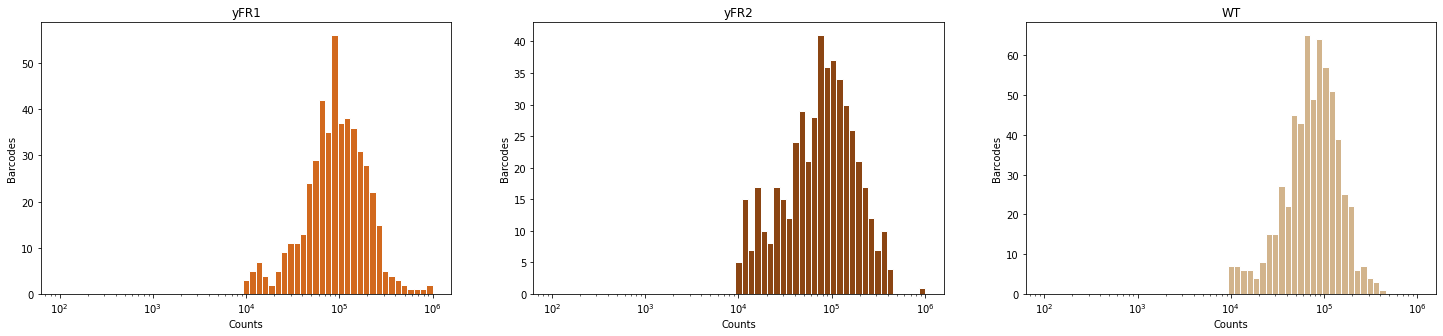

In [15]:
'Plotting histogram of the counts for the barcodes in each parent strain'

figure, ax = plt.subplots(1,3,figsize=(25, 5))
strain_names = ['yFR1','yFR2','WT']
strain_colors = ['Chocolate','Saddlebrown','Tan']

for i in range(NUM_STRAINS):
    'strain_counts -> filtered_counts'
    ax[i].hist(strain_counts[i],bins = np.logspace(2,6,60),ec='white',color=strain_colors[i])
    ax[i].set_xlabel('Counts')
    ax[i].set_ylabel('Barcodes')
    ax[i].set_title(strain_names[i])
    ax[i].set_xscale("log")
    
    print(strain_names[i] + ': {}'.format(np.size(strain_counts[i][strain_counts[i] != 0])))

In [16]:

def timepoint_counts_matrix(tp, EXP_ARRAY, THRES, filtered_barcodes,  NUM_EXPERIMENTS):
    
    """
    Creates a counts matrix for each time point in which the rows correspond to experiments and the
    columns correspond to the counts for a unique barcode
    
    tp: timepoint
    EXP_ARRAY = the array of .npz files containing the sequencing 
    THRES: the threshold of counts defined at the beginning 
    filtered_barcodes = the list of non-repeating barcodes that will be the basis for further analysis
    NUM_EXPERIMENTS = how many poputlations were grown
    
    this matrix will be indexed like timepoint_counts_matrix[timepoint][experiment][barcode]
    
    """

    experiments_barcodes_counts = []

    for i in range(1,NUM_EXPERIMENTS+1):
        experiments_barcodes_counts.append(identify_barcodes_counts(EXP_ARRAY[i][tp],THRES))


    tp_counts_matrix = counts_matrix(filtered_barcodes, NUM_EXPERIMENTS, experiments_barcodes_counts)
    
    return tp_counts_matrix
 
  


In [17]:
'OBJECTIVE 2: AT EACH TIMEPOINT FOR EACH EXPERIMENT, TRACK BARCODE FREQUECIES AND THEIR PARENT STRAINS'

'OBJECTIVE 2: AT EACH TIMEPOINT FOR EACH EXPERIMENT, TRACK BARCODE FREQUECIES AND THEIR PARENT STRAINS'

In [18]:
'Stacking the time matrices in a 3D matrix where the z is timepoint'

time_data = []
for i in range(NUM_TIMEPOINTS):
    time_data.append(timepoint_counts_matrix(i, EXP_ARRAY, THRES, filtered_strain_barcodes,  NUM_EXPERIMENTS))

time_counts_matrix = np.asarray(time_data)
#time_counts_matrix.shape


In [19]:
time_counts_matrix

array([[[65608.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.]],

       [[68658.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.]],

       [[    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.]]])

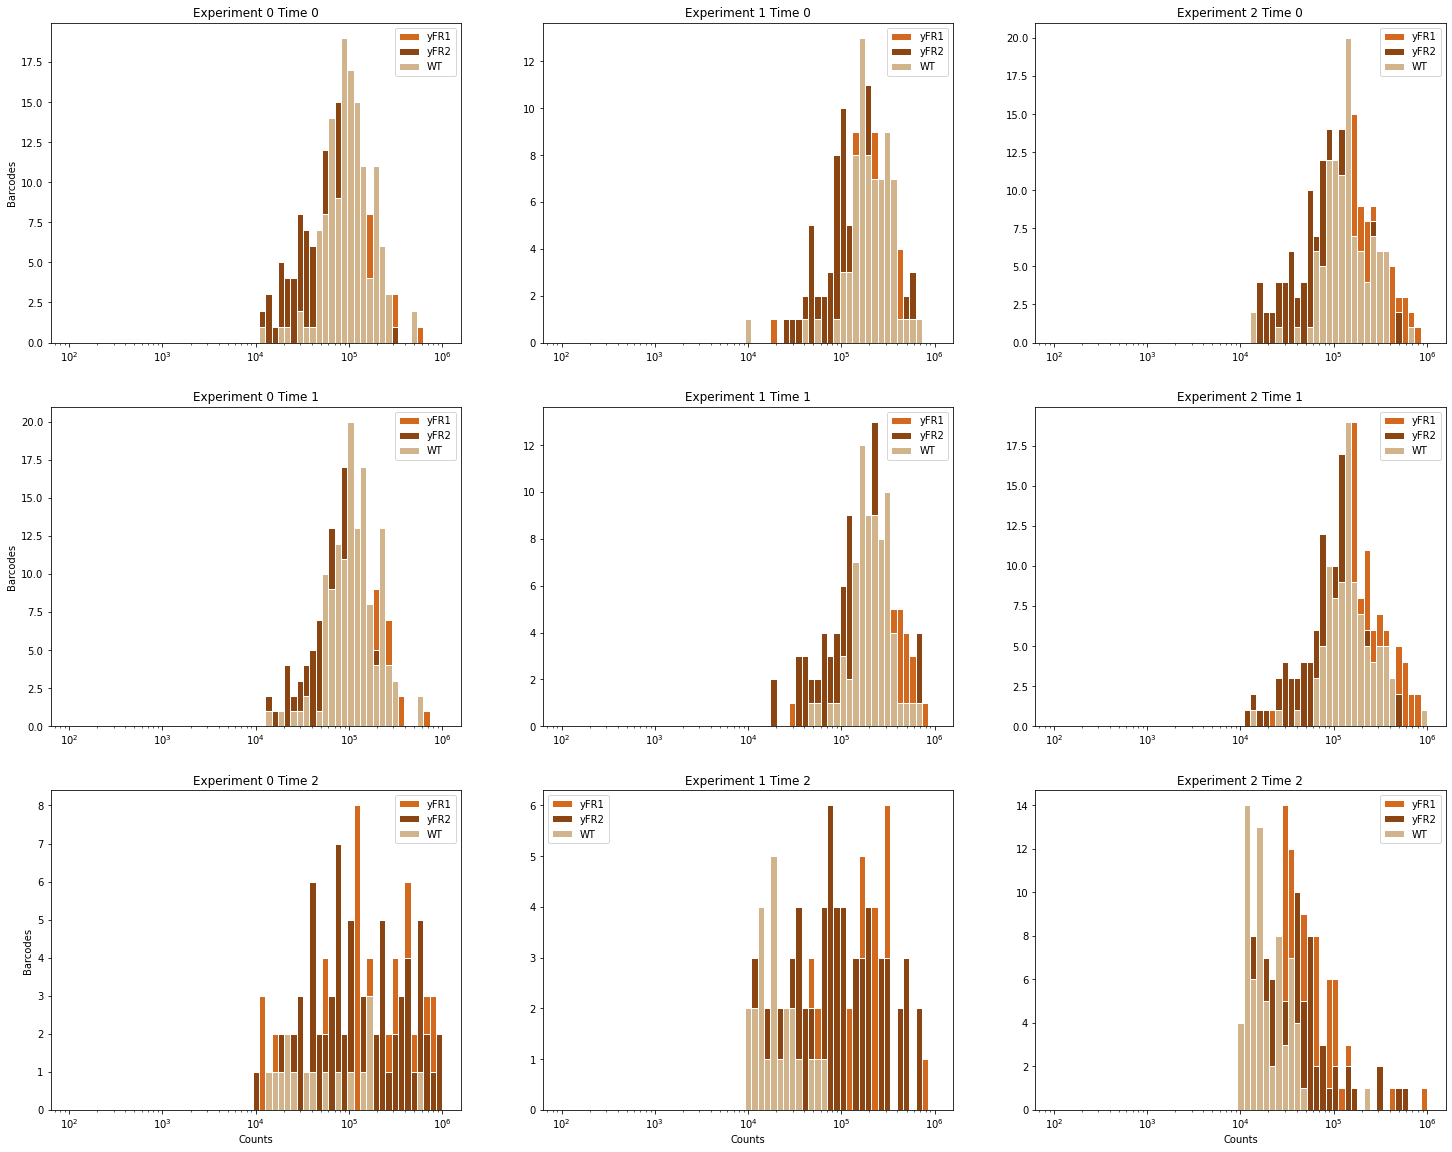

In [20]:

# matching barcodes to the strain they come from
strain_ids = np.zeros_like (filtered_strain_barcodes)

for i in range (NUM_STRAINS) :
    strain_ids[np.where (filtered_strain_counts[i] != 0)] = i
    
# print (strain_ids[:10])  #just checks the frist 10 to show that you only get 0,1,2


fig, ax = plt.subplots(3,3, figsize = (25,20))
strain_colors = [' ',' ',' ']


for i in range(NUM_TIMEPOINTS):
    for j in range(NUM_EXPERIMENTS):
        for k in range(NUM_STRAINS):

            
            ax[i,j].hist(time_counts_matrix[i,j,strain_ids == k],bins = np.logspace(2,6,60),
                         ec='white', color=strain_colors[k])
            ax[i,j].set_xscale("log")
            ax[i,j].set_title('Experiment {} Time {}'.format(j,i))
            
            ax[i,j].legend(strain_names)
        
            if i > 1:
                ax[i,j].set_xlabel('Counts')
            if j < 1:
                ax[i,j].set_ylabel('Barcodes') 
    

plt.show ()




In [21]:
"""
In Kabir's manuscript he had a distribution with read counts as 
low as 10^1. How do i improve my data read out s.t. anything
below 10^4 for t0 and t1 are un-usable data

"""

"\nIn Kabir's manuscript he had a distribution with read counts as \nlow as 10^1. How do i improve my data read out s.t. anything\nbelow 10^4 for t0 and t1 are un-usable data\n\n"

In [22]:
'OBJECTIVE 3: PLOT RELATIVE FREQUENCIES FOR EACH TIMEPOINT'

'OBJECTIVE 3: PLOT RELATIVE FREQUENCIES FOR EACH TIMEPOINT'

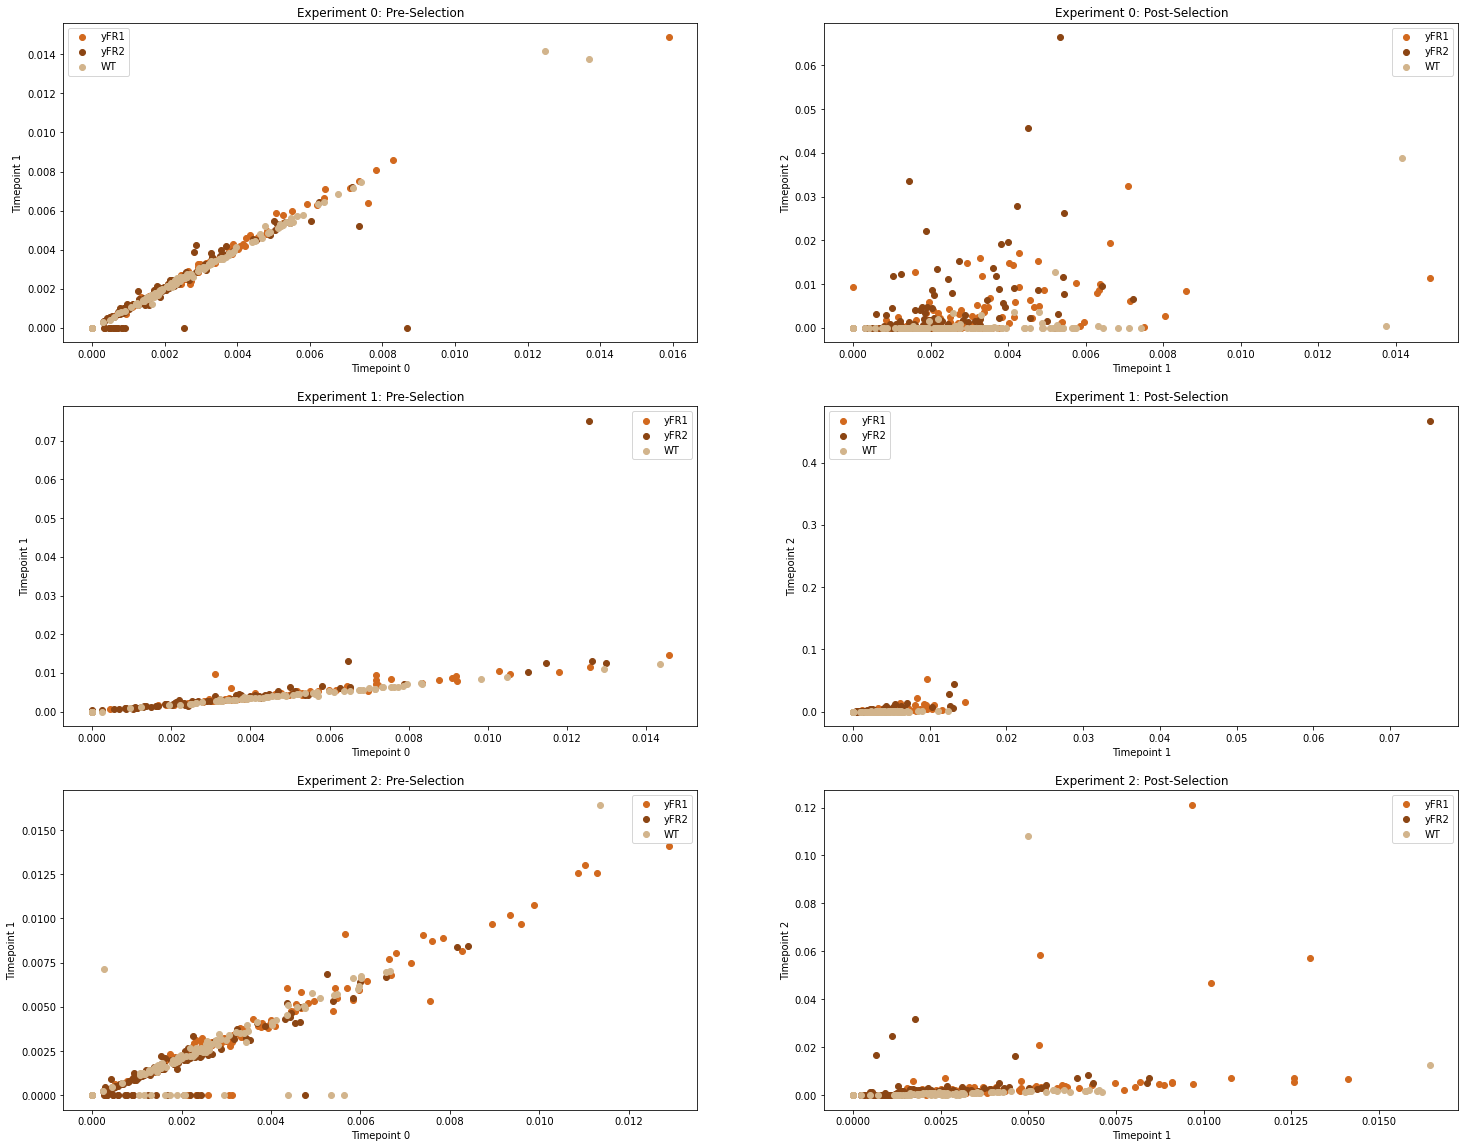

In [23]:
time_frequencies_matrix = np.zeros_like (time_counts_matrix)


for i in range(NUM_TIMEPOINTS):
    for j in range(NUM_EXPERIMENTS):
        for k in range(len(filtered_strain_barcodes)):
            time_frequencies_matrix[i,j,k] = time_counts_matrix[i,j,k]/np.sum(time_counts_matrix[i,j])

fig, ax = plt.subplots(3,2, figsize = (25,20))

for i in range(NUM_EXPERIMENTS):
    for j in range (NUM_TIMEPOINTS-1):
        for k in range(NUM_STRAINS):
            ax[i,j].scatter(time_frequencies_matrix[j,i,strain_ids == k],time_frequencies_matrix[j+1,i,strain_ids == k], c=strain_colors[k])
            
            if j < 1:
                ax[i,j].set_title('Experiment {}: Pre-Selection'.format(i))
            if j >= 1: 
                ax[i,j].set_title('Experiment {}: Post-Selection'.format(i))
            
            ax[i,j].set_xlabel('Timepoint {}'.format(j))
            ax[i,j].set_ylabel('Timepoint {}'.format(j+1))
        ax[i,j].legend(strain_names)



In [25]:
"""OBJECIVE 4"""

'OBJECIVE 4'

In [26]:
'Variables needed'
T_FINAL 
strain_ids 
time_frequencies_matrix
TF_CELL_CONC
SAVED_VOLUME
CELLS_PER_COLONY

'converting frequencies of the final timepoint into colony counts'
#Chooses the frequenices matrices of the final timepoint
tf_freq_matrix = time_frequencies_matrix[T_FINAL]

#Calculates number of cells in the culture for each experiment and stores in matrix
tf_num_cells = np.zeros_like(tf_freq_matrix)
for exp in range (NUM_EXPERIMENTS):
    tf_num_cells[exp] = tf_freq_matrix[exp] * TF_CELL_CONC[exp] * SAVED_VOLUME

#Converts these to number of colonies and stores in matrix
tf_colony_counts = np.zeros_like(tf_freq_matrix)
for exp in range (NUM_EXPERIMENTS):
    tf_colony_counts[exp] = 1/ (CELLS_PER_COLONY[exp] / tf_num_cells[exp] )


/var/folders/7c/76dj47x13vqcyb9yzh27f6s40000gn/T/ipykernel_86171/686544945.py:21: RuntimeWarning: divide by zero encountered in divide
  tf_colony_counts[exp] = 1/ (CELLS_PER_COLONY[exp] / tf_num_cells[exp] )


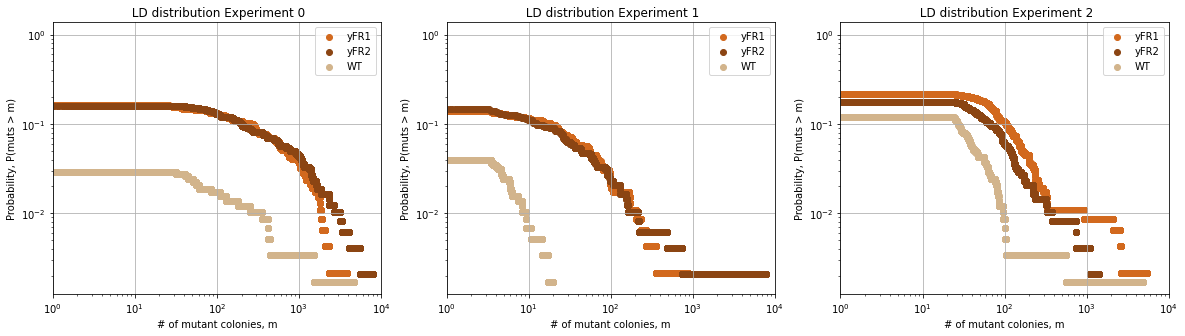

In [27]:

def histogram(data, bins):
    
    min_val = 0 #min(data)
    max_val = max(data)
    
    bin_width = (max_val - min_val) / bins
    
    
    histogram_counts = [0] * bins # Initialize the histogram counts
    
    # Loop through the data and count the number of values in each bin
    for value in data:
        bin_index = int((value - min_val) / bin_width)
        if bin_index == bins:
            bin_index -= 1  # In case the value is exactly equal to max_val
        histogram_counts[bin_index] += 1
    
    return histogram_counts, min_val, max_val, bin_width


fig, ax = plt.subplots(1,3, figsize = (20,5))

for i in range(NUM_STRAINS):
    for j in range(NUM_EXPERIMENTS):

        num_bins = 100000

        hist_counts, min_val, max_val, bin_width = histogram(tf_colony_counts[j,strain_ids == i], bins=num_bins)

        bin_ranges = [min_val + k * bin_width for k in range(num_bins)]
        bin_ranges.append(max_val)  

        cumul_hist = np.cumsum(hist_counts[::-1])[::-1]
        cumul_hist = cumul_hist / np.max(cumul_hist) #FIX THIS LATER
        

        
        ax[j].scatter(bin_ranges[:-1], cumul_hist, marker='o', color=strain_colors[i])
        ax[j].set_xscale('log')
        ax[j].set_yscale('log')
        #ax[j].set_ylim([1e-3,2])
        ax[j].set_xlim([1,1e4])
        ax[j].set_xlabel('# of mutant colonies, m')
        ax[j].set_ylabel('Probability, P(muts > m)')
        ax[j].set_title(' LD distribution Experiment {}'.format(j))
        ax[j].legend(strain_names)
        ax[j].grid(True)



In [28]:
def p0_mu(exp, strain):
    num_barcodes_strains = [482,484,598]

    #Nf = average final cell number in cultures
    Nf = TF_CELL_CONC[exp] 

    #viability = num colonies / num of cells plated
    num_colonies = np.size(np.nonzero(time_counts_matrix[2,exp,strain_ids == strain]))
    num_cells_plated = np.size(np.nonzero(time_counts_matrix[0,exp,strain_ids == strain]))
    viability = num_colonies/ num_cells_plated
   
    #p0 = num bcds with 0 colonies / total number of barcodes that went in
    p0 = (np.size(np.nonzero(time_counts_matrix[0,exp,strain_ids == strain])) - np.size(np.nonzero(time_counts_matrix[2,exp,strain_ids == strain]))) / np.size(np.nonzero(time_counts_matrix[0,exp,strain_ids == strain]))
          
          """
          Finds the number of barcodes with non-zero colonies present before seaprep for a particular strain
          then subtracts from that the number of barcodes with non-zero colonies present at the final timepoint 
          for that strain. This tells us how many barcodes have 0 colonies. Then we devide by the number of barcodes
          at before seaprep. 
          """
        
    mu = -math.log(p0) / (viability * Nf)
    
    return mu


In [29]:
mu_matrix = np.zeros((NUM_EXPERIMENTS,NUM_STRAINS))

for i in range(len(mu_matrix)):
    for j in range(len(mu_matrix)):
        mu_matrix[i,j] = p0_mu(i,j)
        
print(mu_matrix)
print('This matrix reads mutation rates for yfr1, yfr2, wt from right to left. Exp 0,1,2 from top to bottom')


[[9.40619422e-07 8.63196903e-07 5.94409759e-07]
 [1.03348260e-06 1.01449415e-06 4.61970900e-07]
 [2.29796170e-05 1.57261251e-05 1.59428282e-05]]
This matrix reads mutation rates for yfr1, yfr2, wt from right to left. Exp 0,1,2 from top to bottom
